## Import libraries

In [12]:
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

import pandas as pd
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob


import warnings

warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

from numpy import loadtxt
from xgboost import XGBRegressor
from xgboost import plot_importance

## Define reusable functions

#### Function for reading data from model dataset

In [25]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',', index_col=0)
    #df_data.columns=[]
    return df_data

## Read pre-processed multi-variable dataset

#### Set python variables

In [14]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data.csv"

#### Read dataset into pandas dataframe

In [33]:
# Read file
df_model_data = read_data(f'{fpath}\{fname_model_data}')

In [34]:
df_model_data

,Year,Month,temp_mean,temp_min,temp_max,demand_mean,total_consumption,demand_max,demand_mean_max,pv_capacity,population,gsp
0,2010,1,20.868008,1.6,41.1,8941.450389,6554083.135,13765.04,10613.530000,28278.392,7110454,44504.250000
1,2010,2,20.218907,3.2,35.4,8855.467677,5831325.465,13377.27,10380.667857,32153.986,7119405,44504.250000
2,2010,3,19.828286,6.3,34.7,8698.725127,6319623.805,11991.47,10132.978710,38195.588,7128356,44504.250000
3,2010,4,17.593856,6.5,29.9,8452.863411,5984627.295,11436.13,9804.072333,45142.723,7133668,44504.250000
4,2010,5,15.323485,3.1,28.4,8897.770510,6459781.390,12386.49,10558.023548,54370.332,7138980,44504.250000
...,...,...,...,...,...,...,...,...,...,...,...,...
139,2021,8,21.104167,16.9,30.7,7368.353056,530521.420,9043.62,8410.176667,3954209.744,8091356,57391.083333
140,2021,9,20.999306,14.2,27.5,7229.393819,520516.355,9206.19,8469.680000,4033918.477,8088503,57391.083333
141,2021,10,21.084722,14.8,26.9,7209.823194,519107.270,8841.21,8575.093333,4112353.036,8092743,57391.083333
142,2021,11,22.118056,15.7,27.3,7649.492569,550763.465,9573.70,9336.970000,4192992.282,8096983,57391.083333


## Split data into Response (y) and Independent (X) variable arrays

In [35]:
y = df_model_data['demand_max']

X = df_model_data.drop('demand_max', axis=1, inplace=False)

In [53]:
y

0      13765.04
1      13377.27
2      11991.47
3      11436.13
4      12386.49
         ...   
139     9043.62
140     9206.19
141     8841.21
142     9573.70
143    10376.04
Name: demand_max, Length: 144, dtype: float64

In [36]:
X

,Year,Month,temp_mean,temp_min,temp_max,demand_mean,total_consumption,demand_mean_max,pv_capacity,population,gsp
0,2010,1,20.868008,1.6,41.1,8941.450389,6554083.135,10613.530000,28278.392,7110454,44504.250000
1,2010,2,20.218907,3.2,35.4,8855.467677,5831325.465,10380.667857,32153.986,7119405,44504.250000
2,2010,3,19.828286,6.3,34.7,8698.725127,6319623.805,10132.978710,38195.588,7128356,44504.250000
3,2010,4,17.593856,6.5,29.9,8452.863411,5984627.295,9804.072333,45142.723,7133668,44504.250000
4,2010,5,15.323485,3.1,28.4,8897.770510,6459781.390,10558.023548,54370.332,7138980,44504.250000
...,...,...,...,...,...,...,...,...,...,...,...
139,2021,8,21.104167,16.9,30.7,7368.353056,530521.420,8410.176667,3954209.744,8091356,57391.083333
140,2021,9,20.999306,14.2,27.5,7229.393819,520516.355,8469.680000,4033918.477,8088503,57391.083333
141,2021,10,21.084722,14.8,26.9,7209.823194,519107.270,8575.093333,4112353.036,8092743,57391.083333
142,2021,11,22.118056,15.7,27.3,7649.492569,550763.465,9336.970000,4192992.282,8096983,57391.083333


## Fit XGBoost Regression model and plot feature importance chart

In [47]:
model = XGBRegressor(importance_type='gain')
model.fit(X, y)
importances = model.feature_importances_
s_gain = pd.Series(importances, index=X.columns, name='gain').sort_values()

In [48]:
model = XGBRegressor(importance_type='weight')
model.fit(X, y)

importances = model.feature_importances_
s_weight = pd.Series(importances, index=X.columns, name='weight').sort_values()

In [49]:
model = XGBRegressor(importance_type='cover')
model.fit(X, y)

importances = model.feature_importances_
s_cover = pd.Series(importances, index=X.columns, name='cover').sort_values()

In [50]:
df_result = pd.concat([s_gain, s_cover, s_weight], axis=1) 

<Axes: title={'center': 'Feature importance'}>

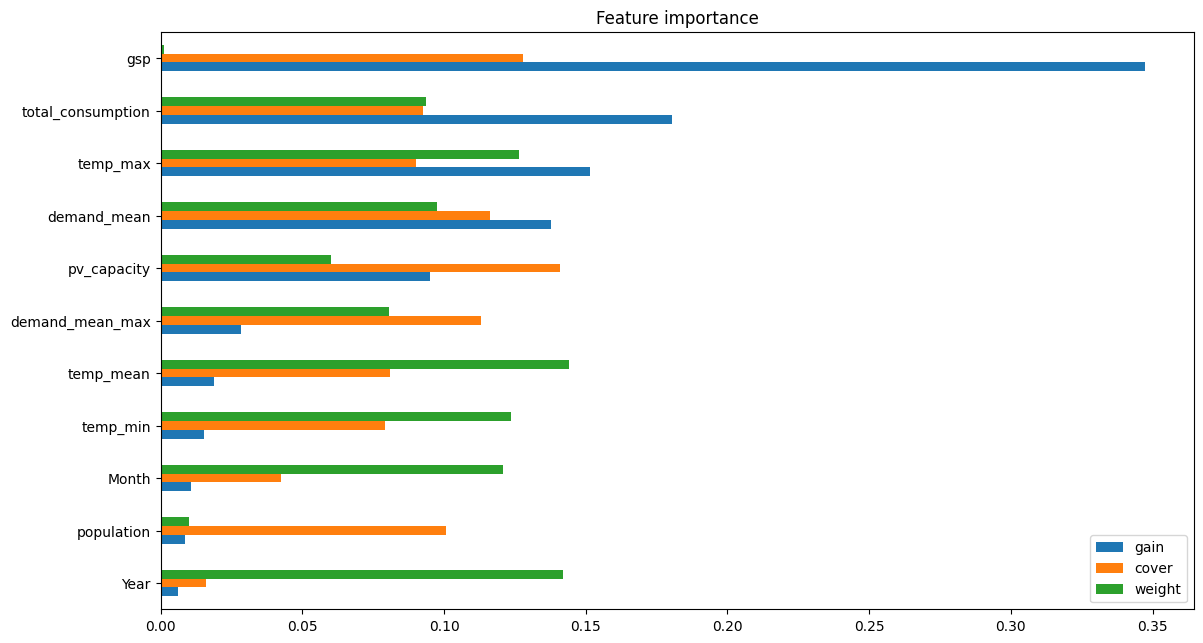

In [52]:
df_result.plot.barh(figsize=(1280/96, 720/96), title='Feature importance')

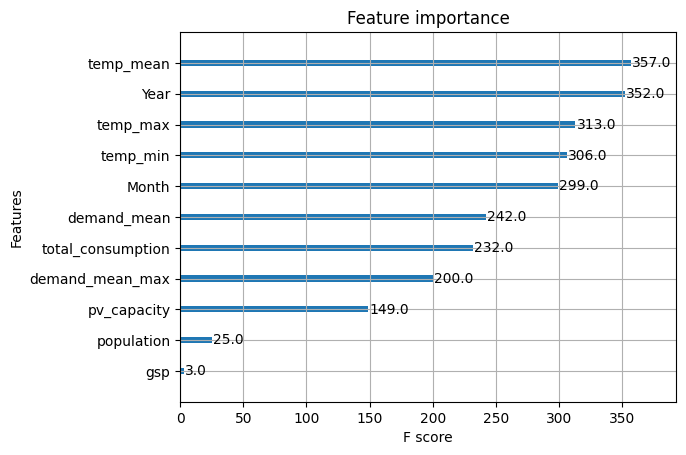

In [55]:
plot_importance(model)
plt.show()